In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)

    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:
regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None, output_distribution='uniform')


In [6]:
%%time

## generate and save linkage matricies for each region
for region_id, _ in region_hulls.loc[[151676]].iterrows():
    data = read_region_morphotope_data(region_id, scalar)
    linkage_matrix = get_morphotope_linkage(data)
    np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

processing 151676
CPU times: user 281 ms, sys: 63.8 ms, total: 344 ms
Wall time: 273 ms


### Setup regional cutoff to merge regional morphotopes

In [7]:
regional_cutoff = 2.5

In [8]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [9]:
np.unique(regional_clusters).shape

(64726,)

In [10]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [11]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)

In [12]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)

In [13]:
vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

In [14]:
stats = regional_ward_morphotopes_data.describe()
stats.loc['min', ].min(), stats.loc['max', ].max()

(np.float64(0.0), np.float64(1.0))

### Final ward clustering

In [15]:
linkage = 'complete'
metric = 'euclidean'



In [16]:
%%time
# linkage_matrix = get_morphotope_linkage(embedding)

linkage_matrix = get_morphotope_linkage(regional_ward_morphotopes_data)

CPU times: user 2min 10s, sys: 5.43 s, total: 2min 16s
Wall time: 2min 15s


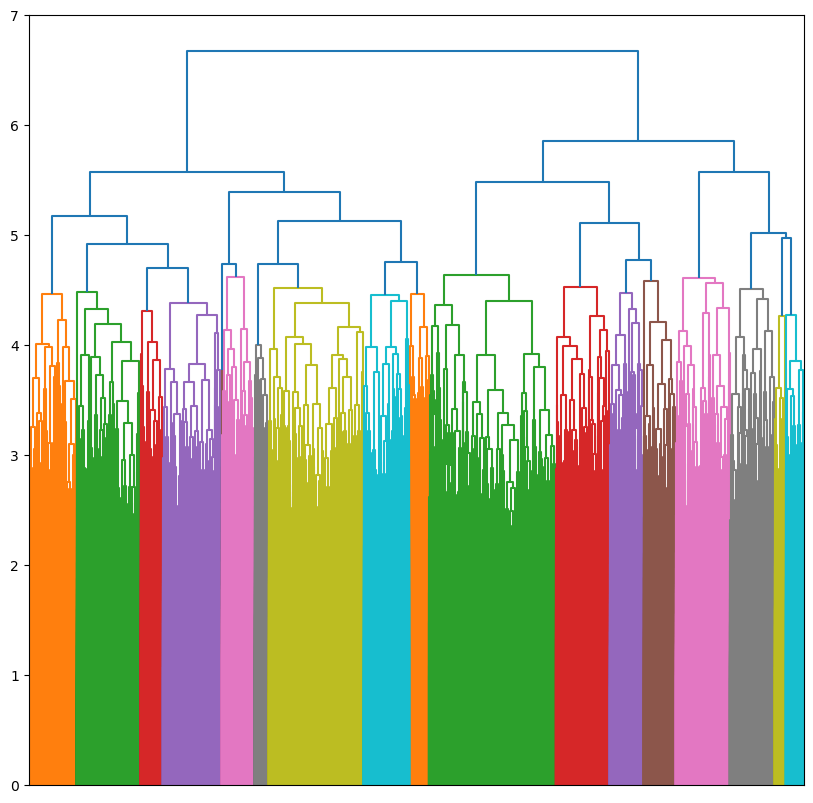

In [17]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax, no_labels=True)

In [18]:
final_cutoff = 0

In [19]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
# clusters_description = regional_ward_morphotopes_data.groupby(final_clusters).mean()
# clusters_description = grouped_data.groupby(final_clusters).mean()
final_clusters.value_counts()

22376    1
27115    1
20919    1
21569    1
17986    1
        ..
20879    1
25041    1
21473    1
27034    1
17859    1
Name: count, Length: 64726, dtype: int64

### Plotting

In [20]:

from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [21]:
region_id = 69333 



# region_id = 8707
# region_id = 5883
# region_id = 86873
# region_id = 38679
# region_id = 55763
# region_id = 107131
# region_id = 99886

region_id = 151676

# region_id= 66593

In [22]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [23]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

# etcs['final'] = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)

In [24]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [25]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [26]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 1.27 s, sys: 153 ms, total: 1.42 s
Wall time: 1.42 s


In [27]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [28]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [464]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')
colorcodes.nunique()

16

In [420]:
etcs.final.value_counts().shape


(15,)

### Interactive dendro

In [421]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

click_history = dict()
click_history_descriptions = dict()

In [41]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
scatter.options({ 'pointConnectionTolerance': 1 })

# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])

In [42]:
scatter.show()

In [471]:
selected_node = scatter.selection()[0]

n = linkage_matrix.shape[0] + 1

left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [472]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

xcnSCl   -0.538801
mtbAli    0.403406
midRea   -0.335954
ldsRea   -0.321654
ssbERI   -0.244336
mibCou   -0.176172
mtbSWR   -0.156324
lddNDe    0.151356
linWID    0.147964
ldsMSL   -0.129866
ldsAre   -0.128200
midAre   -0.121466
ssbCor    0.112065
sdsLen   -0.108195
lcnClo    0.107746
sddAre   -0.106471
mtdMDi   -0.103690
lcdMes   -0.101704
stbSAl    0.099076
ltcBuA    0.098376
dtype: float64

In [473]:


selected_node

np.uint32(127031)

In [474]:
used_keys['lddNDe']

'local node density of street network'

In [475]:
## save for cutting...
click_history[selected_node] = diffs

In [476]:
click_history_descriptions[selected_node] = '66593_91_89 seperate industry and some blocks'

In [477]:
# selected_nodes = [np.uint32(111423),
#  np.uint32(33393),
#  np.uint32(38449),
#  np.uint32(37855),
#  np.uint32(148429),
#  np.uint32(72344),
#  np.uint32(146708),
#  np.uint32(121375),
#  np.uint32(47156),
#  np.uint32(63627),
#  np.uint32(113183),
#  np.uint32(33392),
# np.uint32(33391)
#                  ]

# # selected_nodes = click_history.keys()

In [478]:
## assign clusters

In [479]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [480]:


# for selected_node in [6421, 6887, 28557, 15017, 35908]: - hierarchy without lithuania


for selected_node in click_history_descriptions.keys():
    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

In [481]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [482]:

merged_clusters = grouping[final_cutoff]
merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [483]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [484]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')

In [485]:
click_history_descriptions

{np.uint32(94142): '69333_849_123 vinohrady split from medieval and noise',
 np.uint32(31594): '69333_849_15 medieval split from vinohrady and noise',
 np.uint32(64720): '86873_2159_1 sparse ajacant structures from sparse hosues and industry',
 np.uint32(127851): '69333_849_529 split of sparse from industrial + block housing',
 np.uint32(62541): '69333_849_746 split ofindustrial and block housing',
 np.uint32(33467): '69333_849_325 transitionary (vinohrady-like) from houses',
 np.uint32(21206): '5883_0_80 freiburg city centre from row housing',
 np.uint32(27994): '5883_0_12 freiburg  row housing from others',
 np.uint32(29416): '5883_0_225 freiburg almost blocks from square shaped housing ',
 np.uint32(18881): '5883_0_75 freiburg houses from apartment like',
 np.uint32(123368): '38679_5_1590 seperate industry and some blocks',
 np.uint32(62309): '99886_144_25 seperate industry and some blocks',
 np.uint32(62308): '151675_568_41 seperate industry and some blocks',
 np.uint32(125859): '1

In [486]:
scatter_df.loc[click_history_descriptions.keys()]

,child,parent,dist,size,x,y,group1,order1
94142,129282.0,129318.0,3.974562,1422.0,5.723044e+05,3.974562,64695.0,3
31594,127324.0,128036.0,2.936556,251.0,6.281379e+05,2.936556,64465.0,3
64720,129406.0,129408.0,4.971145,2412.0,1.265906e+06,4.971145,64714.0,2
127851,129127.0,129235.0,3.608248,818.0,1.252657e+06,3.608248,64680.0,3
62541,118430.0,120738.0,2.032077,54.0,1.250198e+06,2.032077,59912.0,1
33467,129353.0,129356.0,4.159924,971.0,6.600612e+05,4.159924,64673.0,2
21206,129113.0,129308.0,3.961836,1170.0,4.091271e+05,3.961836,64645.0,2
27994,129388.0,129398.0,4.374658,6789.0,4.897929e+05,4.374658,64690.0,2
29416,128841.0,128978.0,3.747684,665.0,5.815084e+05,3.747684,64647.0,1
18881,129395.0,129397.0,4.618155,2742.0,3.459715e+05,4.618155,64706.0,2


In [487]:
merged_clusters.value_counts().sort_index()

0      3284
1       785
2      3505
3      1144
4     12110
5      1156
6      1598
7     10601
8      1558
9      4025
10      429
11     1454
12     5520
13     4455
14     1165
15      281
16      515
17      211
18      335
19      140
20     4545
21      525
22     2830
23      446
24      757
25       40
26       13
27      294
28      371
29      137
30      385
31       41
32        3
33       38
34       15
35        7
36        8
Name: count, dtype: int64

In [491]:
pd.Series(click_history_descriptions).to_csv('/data/uscuni-ulce/processed_data/clusters/manual_cuts_v1.csv')

In [488]:
merged_clusters.to_frame().to_parquet('/data/uscuni-ulce/processed_data/clusters/clusters_v1.pq')

## hierarchy of final clusters

In [ ]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)


In [707]:
fdata.to_parquet('../data/cluster_data.pq')


In [600]:
fdata = grouped_data.groupby(merged_clusters).median().fillna(0)
scalar = StandardScaler()
vals = scalar.fit_transform(fdata)
fdata = pd.DataFrame(vals, index=fdata.index, columns=fdata.columns)

In [601]:
linkage = 'complete'
metric = 'euclidean'
linkage_matrix = get_morphotope_linkage(fdata)

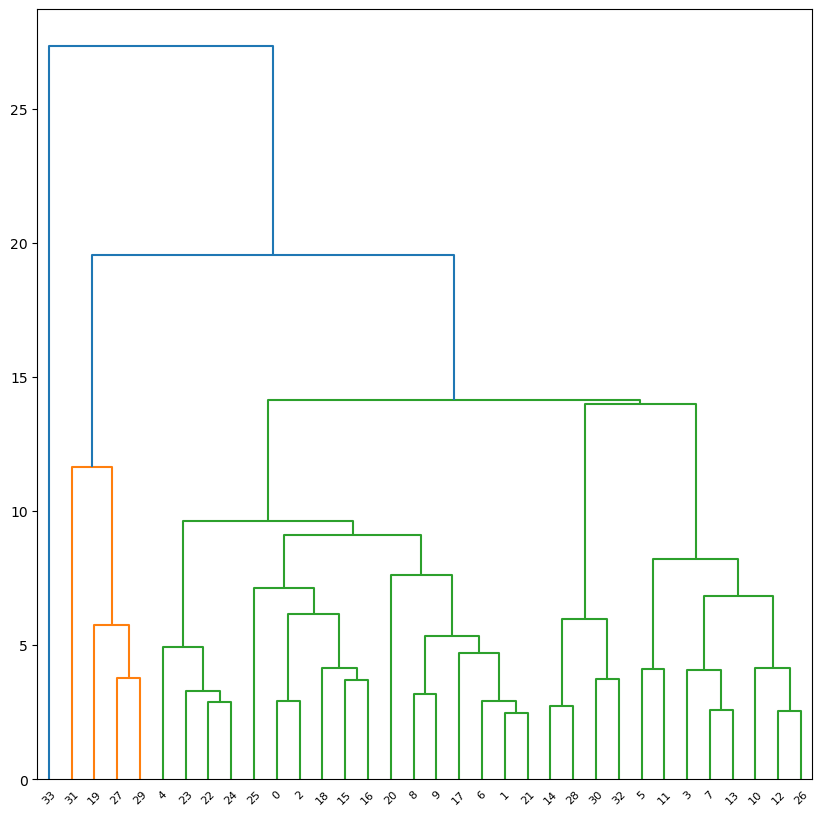

In [602]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix,ax=ax)

In [622]:
etcs[etcs.final == 28].explore(prefer_canvas=True, tiles='cartodb.positron')

In [574]:
final_cutoff = 8
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, fdata.index)
final_clusters.value_counts()

5    7
4    6
8    6
3    4
6    4
1    3
7    2
2    1
9    1
Name: count, dtype: int64

## assign to etcs

In [89]:
from core.cluster_validation import get_color
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [90]:
region_id = 5883

In [91]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs.shape

(70893, 8)

In [92]:
# region_hulls.explore()

In [93]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [94]:
# etcs['final'] = etcs.final.map(final_clusters).values

In [180]:
region_hulls

,convex_hull
labels,
4,"POLYGON ((4122200 3045600, 4121500 3045900, 40..."
10,"POLYGON ((4068900 3057300, 4051000 3064300, 40..."
132,"POLYGON ((4053100 3049800, 4050900 3053000, 40..."
134,"POLYGON ((4052500 3093600, 4052200 3093700, 40..."
286,"POLYGON ((4060600 3103900, 4057000 3104200, 40..."
...,...
149997,"POLYGON ((5253200 3642300, 5245600 3647000, 52..."
150044,"POLYGON ((5265700 3578300, 5263400 3578400, 52..."
151676,"POLYGON ((5285400 3549200, 5284800 3549900, 52..."


In [95]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = merged_colors.loc[etcs.final].values.astype('uint8')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 271 ms, sys: 35.9 ms, total: 307 ms
Wall time: 301 ms


In [96]:
# layer.get_fill_color = get_color(etcs.final.map(final_clusters).values.astype(int))

In [97]:
etcs.final.nunique()

24

In [780]:
etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

In [25]:
merged_colors.shape

(36, 3)

### Assign all regions

In [492]:
merged_clusters = pd.read_parquet('/data/uscuni-ulce/processed_data/clusters/clusters_v1.pq')[0]
merged_clusters.nunique()

37

In [493]:
%%time
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
    etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")
    etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


In [494]:
fdata = regional_ward_morphotopes_data.groupby(merged_clusters).median()

In [495]:
fdata.to_parquet('/data/uscuni-ulce/processed_data/clusters/fdata.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[np.int64(0)]` which will be converted to string and not roundtrip correctly.
  impl.write(


In [179]:
fdata.loc[[12, 14]].style.background_gradient(axis=1, cmap="BuGn")

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,licBAD,misBAD,midBAD
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12,0.949392,0.951288,0.000000,0.129604,0.365866,0.397544,0.697739,0.113284,0.962080,0.365876,0.000000,0.000000,0.794328,0.729229,0.561156,0.912725,0.910237,0.608379,0.756360,0.407153,0.718838,0.305305,0.758153,0.109834,0.892326,0.860711,0.354001,0.509510,0.327283,0.493792,0.518678,0.539544,0.388718,0.304300,0.316437,0.731058,0.000000,0.775099,0.803644,0.242743,0.758855,0.937025,0.940553,0.470927,0.568215,0.065321,0.954162,0.058140,0.217340,0.806880,0.000000,0.827112,0.792301,0.195136,0.774896,0.366633,0.807893,0.903122,0.903122,0.972259,0.964064,0.969450,0.969404
14,0.684898,0.685848,0.000000,0.359421,0.365866,0.534604,0.675351,0.277119,0.717966,0.407914,0.429208,0.000000,0.566727,0.539540,0.572458,0.707177,0.743272,0.635159,0.823425,0.367828,0.842014,0.684184,0.834449,0.248179,0.731738,0.803845,0.638370,0.509510,0.373127,0.522705,0.435435,0.546547,0.329126,0.165608,0.168338,0.778787,0.000000,0.834276,0.827832,0.672673,0.834812,0.758333,0.745006,0.377519,0.388121,0.242390,0.768065,0.224282,0.276417,0.816385,0.577077,0.573480,0.566302,0.324356,0.580583,0.385610,0.597236,0.597700,0.597700,0.733437,0.672287,0.779447,0.776405


### Tree comparisons

In [224]:
from sklearn.neighbors import KDTree

In [225]:
tree = KDTree(regional_ward_morphotopes_data.values)

In [527]:
dists, idxs = tree.query(regional_ward_morphotopes_data.loc[['69333_66']], k=100)

In [528]:
regional_ward_morphotopes_data.iloc[idxs[0]].index

Index(['69333_66', '62954_18', '114311_66', '35141_1', '97745_5', '78792_11',
       '1154_19', '109491_60', '105385_4', '107131_445', '97745_3',
       '105090_15', '78938_32', '93793_17', '72396_10', '61183_2', '116866_31',
       '107131_447', '86873_39', '67156_11', '62954_16', '83538_29',
       '80404_68', '18557_91', '51289_3', '130658_17', '64220_42', '75642_5',
       '62193_4', '90196_6', '87947_3', '93167_16', '73611_9', '107131_441',
       '114311_65', '84554_38', '108884_27', '1154_18', '61187_17',
       '109491_63', '110908_2', '103561_13', '107131_456', '90770_55',
       '67803_4', '93504_7', '82514_3', '120961_8', '114311_64', '78938_31',
       '53525_2', '86863_4', '116866_32', '97745_6', '90075_1', '93793_10',
       '103713_6', '88950_2', '96465_1', '97978_10', '84962_7', '128286_16',
       '93167_15', '109491_59', '80313_11', '102814_9', '84420_6', '55763_24',
       '85156_4', '89921_2', '72507_21', '76038_20', '129730_34', '82773_14',
       '96727_11', '7547

In [139]:
# etcs[etcs.regional == '69333_64'].explore()